# Animation of tajectory of samples from Projected Langevin dynamics and comparison with optimal coupling

## Gaussian vs Exponential (2-well)

### LS

/tmp/ipykernel_6412/615179170.py:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pdf_tgt /= np.trapz(pdf_tgt, y_grid)         # or np.trapezoid
/home/kleon/anaconda3/envs/stochastic/lib/python3.12/site-packages/scipy/interpolate/_cubic.py:157: RuntimeWarning: overflow encountered in divide
  c[0] = t / dxr


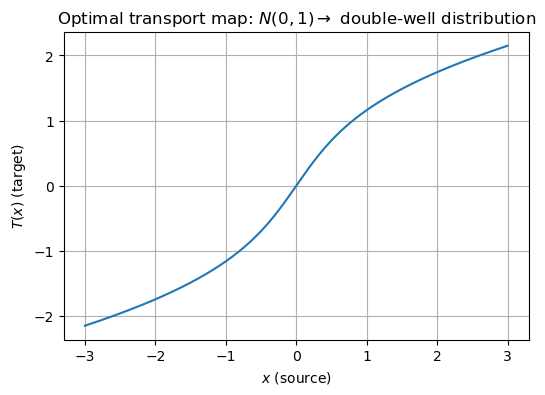

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import PchipInterpolator
import scipy.linalg
import scipy.stats as st

# ------------------------------------------------------------------
# source and unnormalised target density
# ------------------------------------------------------------------
phi = st.norm()                              # Φ(x)
beta = 1
V    = lambda y: 0.25*y**4 - 0.5*y**2
p_unn = lambda y: np.exp(-beta*V(y))         # e^{-βV(y)}

# ------------------------------------------------------------------
# build target CDF on a grid
# ------------------------------------------------------------------
y_grid = np.linspace(-6, 6, 40001)
pdf_tgt = p_unn(y_grid)
pdf_tgt /= np.trapz(pdf_tgt, y_grid)         # or np.trapezoid
cdf_tgt = cumulative_trapezoid(pdf_tgt, y_grid, initial=0.0)

# keep only strictly increasing part (drop the flat tails)
mask = np.concatenate(([True], np.diff(cdf_tgt) > 0))
cdf_inc = cdf_tgt[mask]
y_inc   = y_grid[mask]

# build the inverse CDF (quantile function)
F_inv = PchipInterpolator(cdf_inc, y_inc)    # monotone C1 inverse

# ------------------------------------------------------------------
# optimal transport map  T(x) = F_target^{-1}(Φ(x))
# ------------------------------------------------------------------
def T(x):
    return F_inv(phi.cdf(x))

# ------------------------------------------------------------------
# plot the map
# ------------------------------------------------------------------
x_vals = np.linspace(-3, 3, 600)
plt.figure(figsize=(6, 4))
plt.plot(x_vals, T(x_vals))
plt.title('Optimal transport map: $N(0,1) \\to$ double‑well distribution')
plt.xlabel('$x$ (source)')
plt.ylabel('$T(x)$ (target)')
plt.grid()
plt.savefig('optimal_transport_map.png', dpi=300, bbox_inches='tight')
plt.show()


### Empirical computation of Wasserstein distance for 1D

In [3]:
import sys, os

# Add the parent directory (one level up) to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Now you can import from cond_expect_ols.py living in that parent folder
from conditional_expectation_methods import compute_ols_parameters, nadaraya_watson, knn_conditional_expectation_improved
from wasserstein_distances import W2_empirical
from EM import euler_maruyama_coupling
from utils import compute_gradient_U, compute_gradient_V, build_double_well_quantile

In [20]:

F_inv = build_double_well_quantile(beta=1.0, y_min=-6, y_max=6, ny=40_001)
Phi   = st.norm().cdf


def sample_nu(n):
    """Draw n samples from the double‑well distribution ν."""
    return F_inv(Phi(np.random.randn(n)))


# 1. Parameters
num_samples = 1_000
epsilon     = 0.001
T           = 10
N           = 800
k_neighbors = 10
h           = 0.01
dt          = T / N
sqrt_2eps_dt = np.sqrt(2 * epsilon * dt)
seed        = 42

# 2. Initial samples
rng = np.random.RandomState(seed)
X0 = rng.randn(num_samples)
Y0 = sample_nu(num_samples)
W2_sq = W2_empirical(X0, Y0)**2
print(W2_sq) # empirical W2^2 from initial samples


# 3. OLS
errors_OLS, X_traj_OLS, Y_traj_OLS, _ = euler_maruyama_coupling(
    X0, Y0,
    epsilon=epsilon,
    T=T,
    N=N,
    cond_method='ols',     
    h=None,                
    grad_U=compute_gradient_U,
    grad_V=compute_gradient_V,
    compute_W2_sq= None,
    seed=seed
)

# 4. Isotonic regression (optional)
errors_iso, X_traj_iso, Y_traj_iso, _ = euler_maruyama_coupling(
    X0, Y0,
    epsilon=epsilon,
    T=T,
    N=N,
    cond_method='isotonic',    
    h=None,                
    grad_U=compute_gradient_U,
    grad_V=compute_gradient_V,
    compute_W2_sq=None,
    seed=seed
)

# 5. Nadaraya-Watson
errors_Nad, X_traj_Nad, Y_traj_Nad, _ = euler_maruyama_coupling(
    X0, Y0,
    epsilon=epsilon,
    T=T,
    N=N,
    cond_method='nadaraya',
    h=h,
    grad_U=compute_gradient_U,
    grad_V=compute_gradient_V,
    compute_W2_sq=None,
    seed=seed
)

# 6. Clusters (optional)
errs_cl, Xt_cl, Yt_cl, _ = euler_maruyama_coupling(
    X0, Y0,
    epsilon=epsilon,
    T=T,
    N=N,
    cond_method='cluster',
    k=k_neighbors,
    grad_U=compute_gradient_U,
    grad_V=compute_gradient_V,
    compute_W2_sq=None,
    seed=seed
)

# 7. k-NN
errs_knn, Xt_knn, Yt_knn, _ = euler_maruyama_coupling(
    X0, Y0,
    epsilon=epsilon,
    T=T,
    N=N,
    cond_method='knn',
    k=k_neighbors,
    grad_U=compute_gradient_U,
    grad_V=compute_gradient_V,
    compute_W2_sq=None,
    seed=seed
)

errs_knn_imp, Xt_knn_imp, Yt_knn_imp, _ = euler_maruyama_coupling(
    X0, Y0,
    epsilon=epsilon,
    T=T,
    N=N,
    cond_method='knn_improved',
    k=k_neighbors,
    grad_U=compute_gradient_U,
    grad_V=compute_gradient_V,
    compute_W2_sq=None,
    seed=seed
)



/home/kleon/anaconda3/envs/stochastic/lib/python3.12/site-packages/scipy/interpolate/_cubic.py:157: RuntimeWarning: overflow encountered in divide
  c[0] = t / dxr


0.03486998110299891


## Plot L2-errors for all schemes

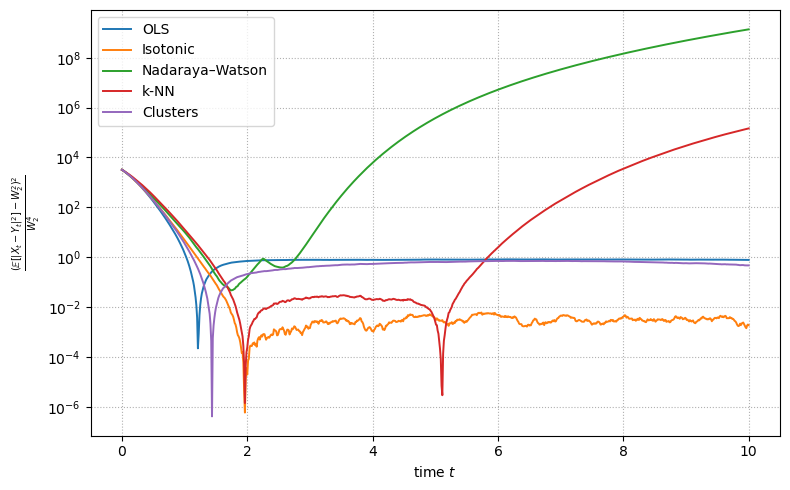

In [21]:
import matplotlib.pyplot as plt

# assume: errors_OLS, errors_iso, errors_Nad, errors_knn, W2_sq, T, N are already defined

t = np.linspace(0, T, N+1)

# compute normalized squared errors
rel_err_OLS    = (errors_OLS - W2_sq)**2 / W2_sq**2
rel_err_iso    = (errors_iso - W2_sq)**2 / W2_sq**2
rel_err_Nad    = (errors_Nad - W2_sq)**2 / W2_sq**2
rel_err_knn    = (errs_knn  - W2_sq)**2 / W2_sq**2
rel_err_cl     = (errs_cl   - W2_sq)**2 / W2_sq**2
# rel_err_knn_imp = (errs_knn_imp - W2_sq)**2 / W2_sq**2

plt.figure(figsize=(8,5))


plt.plot(t, rel_err_OLS,  lw=1.4, label='OLS')
plt.plot(t, rel_err_iso,  lw=1.4, label='Isotonic')
plt.plot(t, rel_err_Nad,  lw=1.4, label='Nadaraya–Watson')
plt.plot(t, rel_err_knn,  lw=1.4, label='k-NN')
plt.plot(t, rel_err_cl,   lw=1.4, label='Clusters')
# plt.plot(t, rel_err_knn_imp, lw=1.4, label='k-NN improved')
# horizontal reference at zero level (optional)
# plt.axhline(0, color='k', linestyle='--', lw=1)

plt.xlabel(r'time $t$')
plt.ylabel(r'$\frac{(\mathbb{E}[|X_t-Y_t|^2]-W_2^2)^2}{W_2^4}$')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
# plt.savefig('em_coupling_relative_error.png', dpi=300, bbox_inches='tight')
plt.show()


In [11]:
import numpy as np
import scipy.stats as st

# --- precompute once ---
x0 = 3.0
tail_frac = 0.2
num_samples = 1_000
eps = 1e-12           # small buffer to avoid exactly 0 or 1

# normal
Phi     = st.norm().cdf
Phi_inv = st.norm().ppf
u0_norm = Phi(-x0)

# double‐well quantiles
ny     = 40_001
U_grid = np.linspace(0, 1, ny)
Y_grid = F_inv(U_grid)
iL     = np.searchsorted(Y_grid, -x0)
iR     = np.searchsorted(Y_grid,  x0)
u0_nu  = U_grid[iL]
u1_nu  = U_grid[iR]

def sample_stratified_normal(n, x0=3.0, tail_frac=0.2):
    n_tail   = int(np.round(n * tail_frac))
    n_center = n - n_tail
    n_tail_l = n_tail // 2
    n_tail_r = n_tail - n_tail_l

    # left‐tail uniforms in (0, u0_norm)
    u_l = np.random.rand(n_tail_l) * (u0_norm - eps) + eps
    # center uniforms in (u0_norm, 1-u0_norm)
    u_c = np.random.rand(n_center) * ((1 - u0_norm) - u0_norm - eps) + (u0_norm + eps/2)
    # right‐tail uniforms in (1-u0_norm, 1)
    u_r = np.random.rand(n_tail_r) * (u0_norm - eps) + (1 - u0_norm + eps)

    u = np.concatenate([u_c, u_l, u_r])
    np.random.shuffle(u)
    return Phi_inv(np.clip(u, eps, 1 - eps))

def sample_stratified_nu(n, x0=3.0, tail_frac=0.2):
    n_tail   = int(np.round(n * tail_frac))
    n_center = n - n_tail
    n_tail_l = n_tail // 2
    n_tail_r = n_tail - n_tail_l

    # left‐tail in (0, u0_nu)
    u_l = np.random.rand(n_tail_l) * (u0_nu - eps) + eps
    # center in (u0_nu, u1_nu)
    u_c = np.random.rand(n_center) * ((u1_nu - u0_nu) - eps) + (u0_nu + eps/2)
    # right‐tail in (u1_nu, 1)
    u_r = np.random.rand(n_tail_r) * ((1 - u1_nu) - eps) + (u1_nu + eps)

    u = np.concatenate([u_c, u_l, u_r])
    np.random.shuffle(u)
    return F_inv(np.clip(u, eps, 1 - eps))

# 2. Initial samples
rng = np.random.RandomState(42)
X0 = sample_stratified_normal(num_samples, x0, tail_frac)
Y0 = sample_stratified_nu     (num_samples, x0, tail_frac)

print("Any NaNs?", np.isnan(X0).any(), np.isnan(Y0).any())  # should be False


# Plain i.i.d. version (now commented out):
# X0 = rng.randn(num_samples)
# Y0 = sample_nu(num_samples)

# Stratified version (20% of samples in |x|>3.0 by default):
X0 = sample_stratified_normal(num_samples, x0=3.0, tail_frac=0.2)
Y0 = sample_stratified_nu     (num_samples, x0=3.0, tail_frac=0.2)

W2_sq = W2_empirical(X0, Y0)**2
print("Empirical W2^2:", W2_sq)

# 7. k-NN
errs_knn, Xt_knn, Yt_knn, _ = euler_maruyama_coupling(
    X0, Y0,
    epsilon=epsilon,
    T=T,
    N=N,
    cond_method='knn',
    k=20,
    grad_U=compute_gradient_U,
    grad_V=compute_gradient_V,
    compute_W2_sq=None,
    seed=seed
)

# errs_knn_imp, Xt_knn_imp, Yt_knn_imp, _ = euler_maruyama_coupling(
#     X0, Y0,
#     epsilon=epsilon,
#     T=T,
#     N=N,
#     cond_method='knn_improved',
#     k=k_neighbors,
#     grad_U=compute_gradient_U,
#     grad_V=compute_gradient_V,
#     compute_W2_sq=None,
#     seed=seed
# )



Any NaNs? False False
Empirical W2^2: 0.0399747618572006


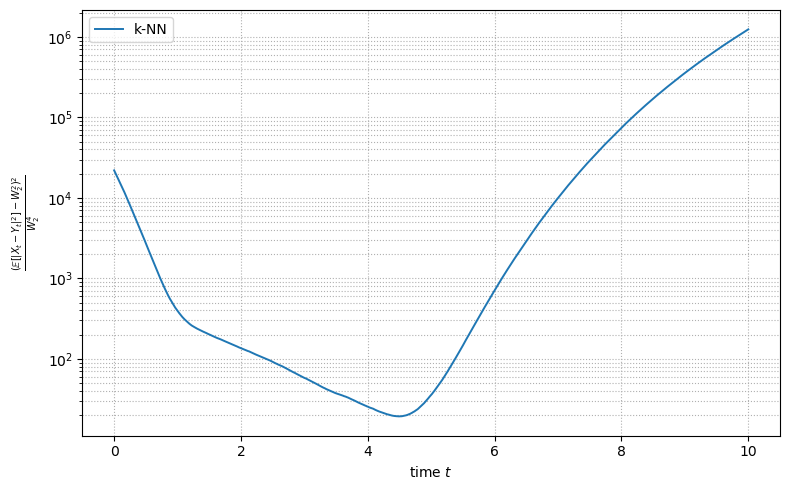

In [12]:
import matplotlib.pyplot as plt

# assume: errors_OLS, errors_iso, errors_Nad, errors_knn, W2_sq, T, N are already defined

t = np.linspace(0, T, N+1)

# compute normalized squared errors
# rel_err_OLS    = (errors_OLS - W2_sq)**2 / W2_sq**2
# rel_err_iso    = (errors_iso - W2_sq)**2 / W2_sq**2
# rel_err_Nad    = (errors_Nad - W2_sq)**2 / W2_sq**2
rel_err_knn    = (errs_knn  - W2_sq)**2 / W2_sq**2
# rel_err_cl     = (errs_cl   - W2_sq)**2 / W2_sq**2
# rel_err_knn_imp = (errs_knn_imp - W2_sq)**2 / W2_sq**2

plt.figure(figsize=(8,5))


# plt.plot(t, rel_err_OLS,  lw=1.4, label='OLS')
# plt.plot(t, rel_err_iso,  lw=1.4, label='Isotonic')
# plt.plot(t, rel_err_Nad,  lw=1.4, label='Nadaraya–Watson')
plt.plot(t, rel_err_knn,  lw=1.4, label='k-NN')
# plt.plot(t, rel_err_cl,   lw=1.4, label='Clusters')
# plt.plot(t, rel_err_knn_imp, lw=1.4, label='k-NN improved')
# horizontal reference at zero level (optional)
# plt.axhline(0, color='k', linestyle='--', lw=1)

plt.xlabel(r'time $t$')
plt.ylabel(r'$\frac{(\mathbb{E}[|X_t-Y_t|^2]-W_2^2)^2}{W_2^4}$')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
# plt.savefig('em_coupling_relative_error.png', dpi=300, bbox_inches='tight')
plt.show()

### OLS animation

/home/kleon/Desktop/epfl/langevinOT_sem_project/code/animations/utils.py:148: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


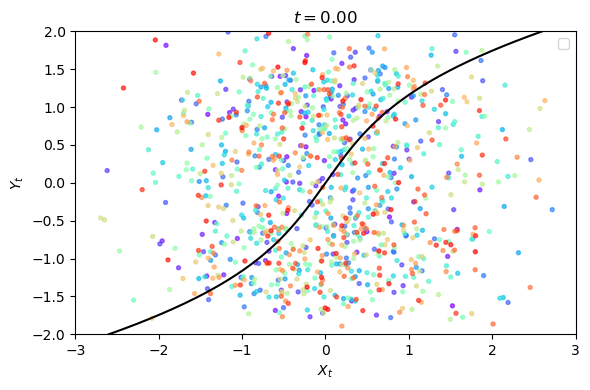

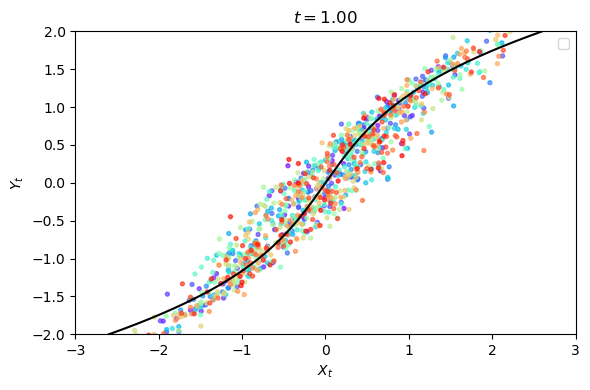

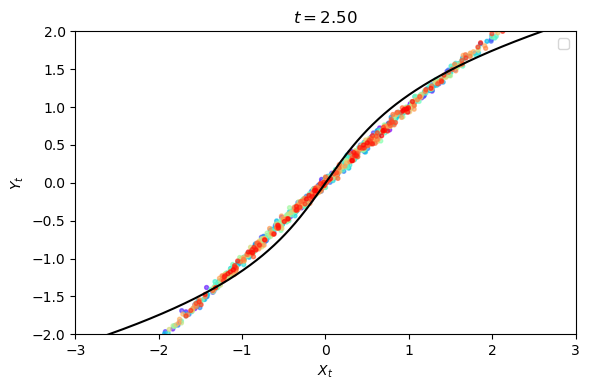

In [6]:
import matplotlib.animation as animation
from utils import animate_coupling, save_scatter_snapshot
# Define the optimal transport map
T_map = lambda x: F_inv(Phi(x))

# Time vector (already defined previously)
# t = np.linspace(0, T, N+1)

# # Call the reusable animation function
# ani = animate_coupling(
#     X_traj, 
#     Y_traj, 
#     errors, 
#     t, 
#     T_map,
#     filepath='coupling_with_OT_curve_poly_fit.mp4',
#     fps=15,
#     interval=60,
#     figsize=(11, 4),
#     cmap='rainbow'
# )
t = np.linspace(0, T, N+1)
snapshot_times = [0.0, 1.0, 2.5]
for tau in snapshot_times:
    save_scatter_snapshot(
        time_point=tau,
        t=t,
        X_traj=X_traj_OLS,
        Y_traj=Y_traj_OLS,
        T_map=T_map,
        filename=f'coupling_with_OT_curve_poly_fit_snapshot_t{tau:.2f}.png'
    )

### Nadaraya-Watson

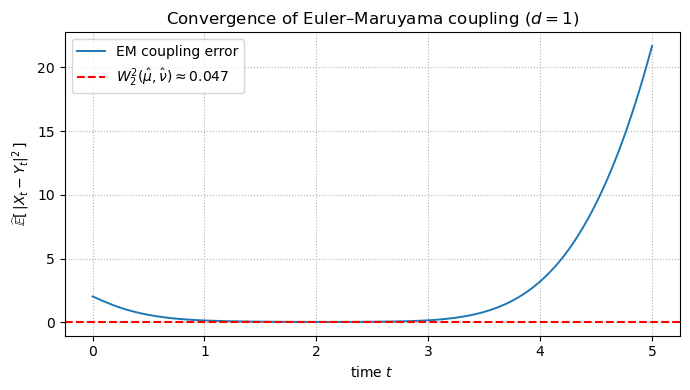

In [ ]:
# Parameters
num_samples = 1_000
epsilon     = 1e-3
T           = 5.0
N           = 500
seed        = 42

# Initial samples
rng = np.random.RandomState(seed)
X0 = rng.randn(num_samples)       # μ = N(0,1)
Y0 = sample_nu(num_samples)       # ν (double well)


# ------------------------------------------------------------------
# 5.  Plot convergence
# ------------------------------------------------------------------
t = np.linspace(0, T, N + 1)
plt.figure(figsize=(7, 4))
plt.plot(t, errors_Nad, lw=1.4, label='EM coupling error')
plt.axhline(
    y=W2_sq,
    color='red',
    linestyle='--',
    label=rf'$W_2^2(\hat\mu,\hat\nu)\approx {W2_sq:.3f}$'
)
plt.xlabel('time $t$')
plt.ylabel(r'$\widehat{\mathbb{E}}[\,|X_t-Y_t|^2\,]$')
plt.legend()
plt.title('Convergence of Euler–Maruyama coupling ($d=1$)')
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()


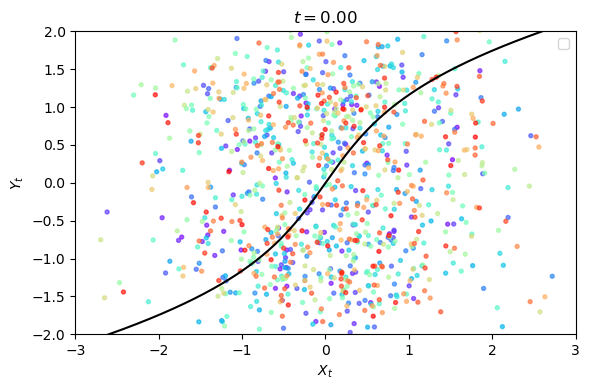

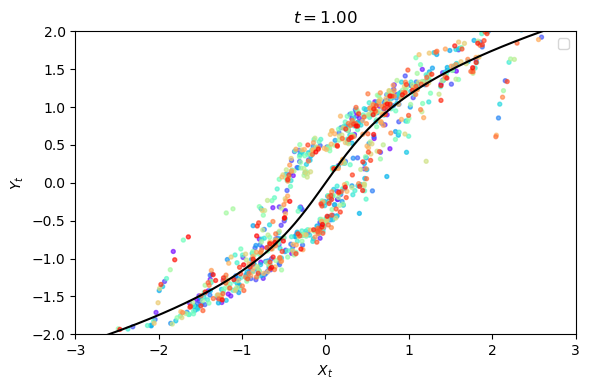

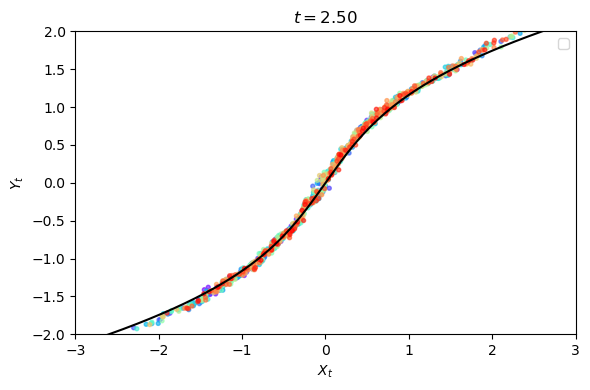

Done: mp4 animation and PNG snapshots saved.


In [20]:

# --- 1) Full mp4 animation with Nadaraya–Watson conditionals ---
# ani = animate_coupling(
#     X_traj, 
#     Y_traj, 
#     errors, 
#     t, 
#     T_map,
#     filepath='coupling_with_OT_curve_nadaraya.mp4',
#     fps=15,
#     interval=60,
#     figsize=(11, 4),
#     cmap='rainbow'
# )

# --- 2) Static snapshots at chosen times ---
snapshot_times = [0.0, 1.0, 2.5]   # in the same units as t
for tau in snapshot_times:
    save_scatter_snapshot(
        time_point=tau,
        t=t,
        X_traj=X_traj_Nad,
        Y_traj=Y_traj_Nad,
        T_map=T_map,
        filename=f'scatter_nw_t{tau:.2f}.png',
        figsize=(6, 4),
        cmap='rainbow'
    )

print("Done: mp4 animation and PNG snapshots saved.")


## Cluster MC method

In [21]:
from sklearn.cluster import KMeans

def cluster_conditional_expectation(X: np.ndarray, 
                                    Y: np.ndarray, 
                                    k: int) -> np.ndarray:
    """
    Estimate E[Y | X] using clustering + Monte Carlo (piecewise-constant).
    
    Parameters
    ----------
    X : array-like, shape (n,)
        Predictor samples.
    Y : array-like, shape (n,)
        Response samples.
    k : int
        Number of clusters for KMeans.
    
    Returns
    -------
    m_hat : np.ndarray, shape (n,)
        Estimated conditional expectation values at each X_i.
    """
    X = np.asarray(X).reshape(-1, 1)
    Y = np.asarray(Y)
    # 1. Cluster X into k clusters
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    labels = kmeans.labels_
    
    # 2. Compute cluster-wise means of Y
    m_hat = np.zeros_like(Y, dtype=float)
    for cluster_id in range(k):
        mask = (labels == cluster_id)
        if np.any(mask):
            m_hat[mask] = Y[mask].mean()
        else:
            m_hat[mask] = 0.0  # fallback if empty cluster
    
    return m_hat

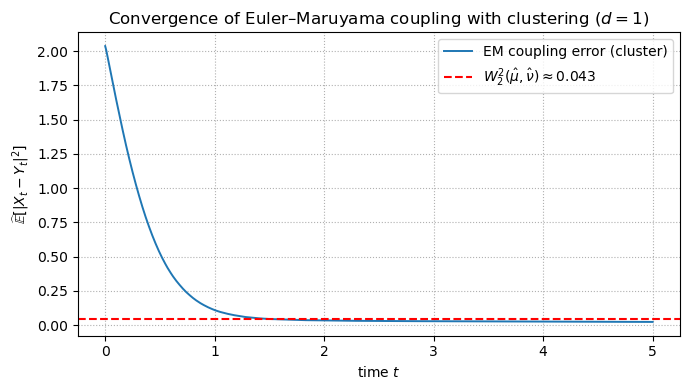

In [ ]:
# Parameters
num_samples = 1_000
epsilon     = 1e-3
T           = 5.0
N           = 500
seed        = 42

# Initial samples
rng = np.random.RandomState(seed)
X0 = rng.randn(num_samples)        # μ = N(0,1)
Y0 = sample_nu(num_samples)        # ν (double well)



# Time grid
t = np.linspace(0, T, N + 1)

# Plot convergence for clustering method
plt.figure(figsize=(7, 4))
plt.plot(t, errs_cl, lw=1.4, label='EM coupling error (cluster)')
plt.axhline(
    y=W2_sq,
    color='red',
    linestyle='--',
    label=rf'$W_2^2(\hat\mu,\hat\nu)\approx {W2_sq:.3f}$'
)
plt.xlabel('time $t$')
plt.ylabel(r'$\widehat{\mathbb{E}}[|X_t-Y_t|^2]$')
plt.legend()
plt.title('Convergence of Euler–Maruyama coupling with clustering ($d=1$)')
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()

Animation saved as coupling_with_OT_curve_cluster.mp4


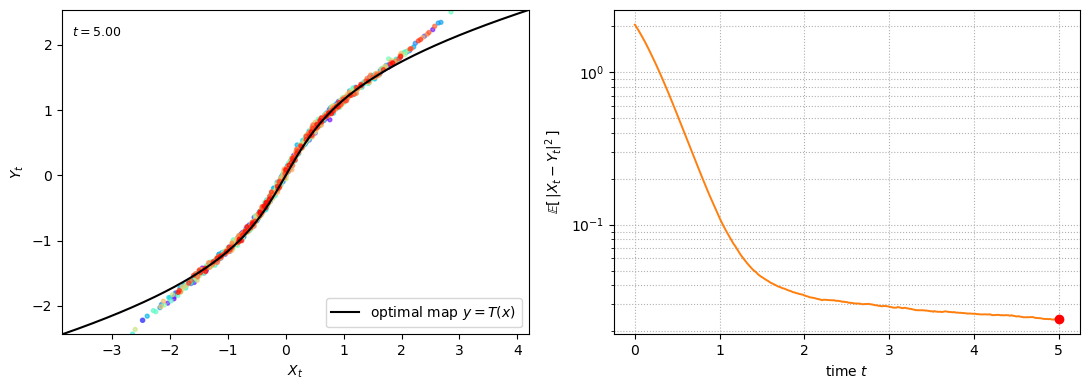

/home/kleon/Desktop/epfl/langevinOT_sem_project/code/animations/utils.py:144: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


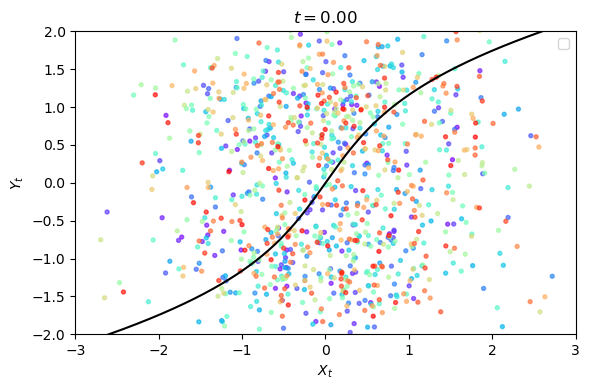

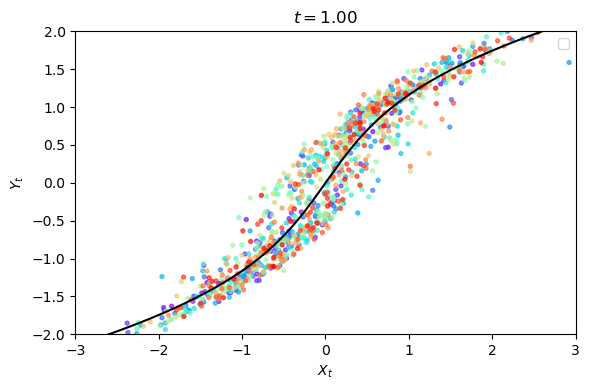

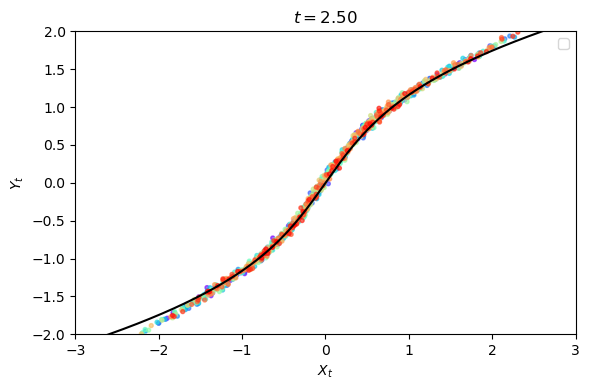

Done: clustering‐based mp4 animation and PNG snapshots saved.


In [ ]:
# --- 1) Full mp4 animation with clustering‐based conditionals ---
ani = animate_coupling(
    Xt_cl, 
    Yt_cl, 
    errs_cl, 
    t, 
    T_map,
    filepath='coupling_with_OT_curve_cluster.mp4',
    fps=15,
    interval=60,
    figsize=(11, 4),
    cmap='rainbow'
)

# --- 2) Static snapshots at chosen times (cluster) ---
snapshot_times = [0.0, 1.0, 2.5]
for tau in snapshot_times:
    save_scatter_snapshot(
        time_point=tau,
        t=t,
        X_traj=Xt_cl,
        Y_traj=Yt_cl,
        T_map=T_map,
        filename=f'scatter_cluster_t{tau:.2f}.png',
        figsize=(6, 4),
        cmap='rainbow'
    )

print("Done: clustering‐based mp4 animation and PNG snapshots saved.")   


## k-NN

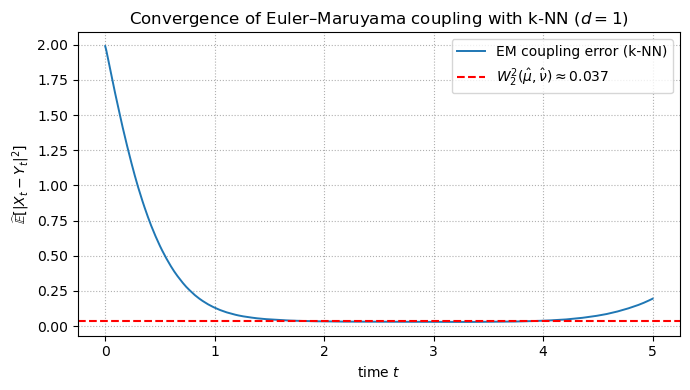

In [ ]:
# Example: Euler–Maruyama coupling using k-NN conditionals
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_samples = 1_000
epsilon     = 1e-3
T           = 5.0
N           = 500
seed        = 42
k_neighbors = 20

# Initial samples
rng = np.random.RandomState(seed)
X0 = rng.randn(num_samples)        # μ = N(0,1)
Y0 = sample_nu(num_samples)        # ν (double well)

# Compute baseline Wasserstein^2
W2_sq = W2_empirical(X0, Y0)**2



# Time grid
t = np.linspace(0, T, N + 1)

# Plot convergence for k-NN method
plt.figure(figsize=(7, 4))
plt.plot(t, errs_knn, lw=1.4, label='EM coupling error (k-NN)')
plt.axhline(
    y=W2_sq,
    color='red',
    linestyle='--',
    label=rf'$W_2^2(\hat\mu,\hat\nu)\approx {W2_sq:.3f}$'
)
plt.xlabel('time $t$')
plt.ylabel(r'$\widehat{\mathbb{E}}[|X_t-Y_t|^2]$')
plt.legend()
plt.title('Convergence of Euler–Maruyama coupling with k-NN ($d=1$)')
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()

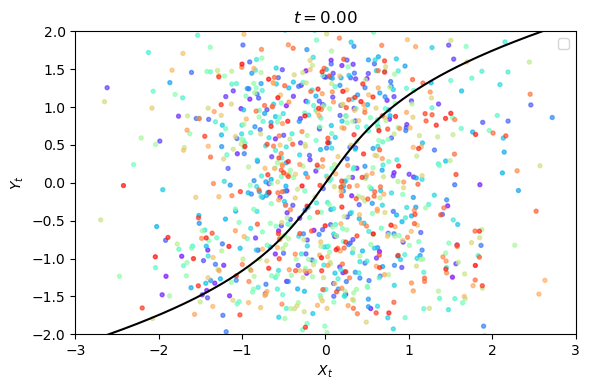

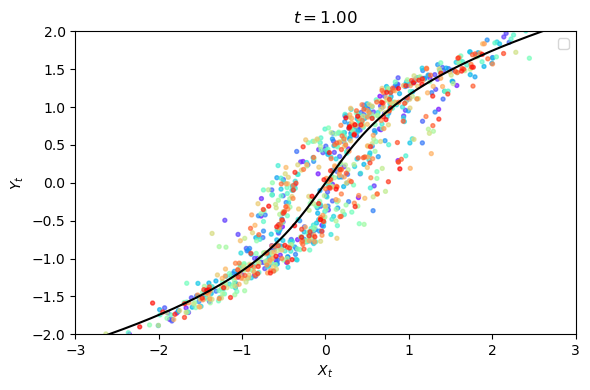

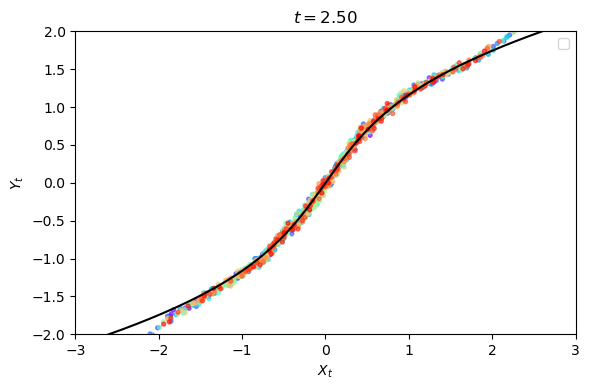

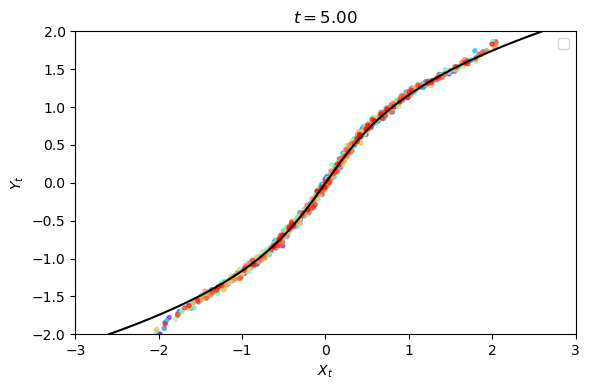

Done: k-NN–based mp4 animation and PNG snapshots saved.


In [11]:
# # --- 1) Full mp4 animation with k-NN–based conditionals ---
# ani_knn = animate_coupling(
#     Xt_knn, 
#     Yt_knn, 
#     errs_knn, 
#     t, 
#     T_map,
#     filepath='coupling_with_OT_curve_knn.mp4',
#     fps=15,
#     interval=60,
#     figsize=(11, 4),
#     cmap='rainbow'
# )

# --- 2) Static snapshots at chosen times (k-NN) ---
snapshot_times = [0.0, 1.0, 2.5, 5.0]
for tau in snapshot_times:
    save_scatter_snapshot(
        time_point=tau,
        t=t,
        X_traj=Xt_knn,
        Y_traj=Yt_knn,
        T_map=T_map,
        filename=f'scatter_knn_t{tau:.2f}.png',
        figsize=(6, 4),
        cmap='rainbow'
    )

print("Done: k-NN–based mp4 animation and PNG snapshots saved.")

### k-NN improved

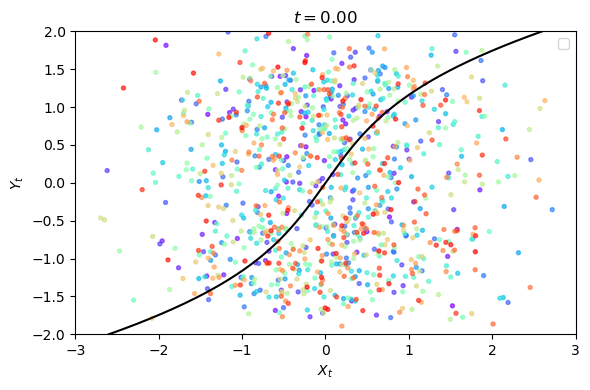

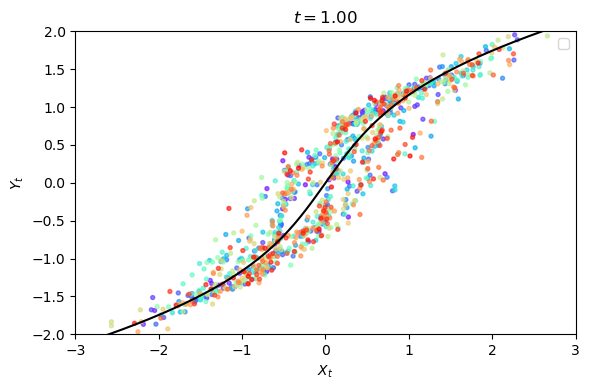

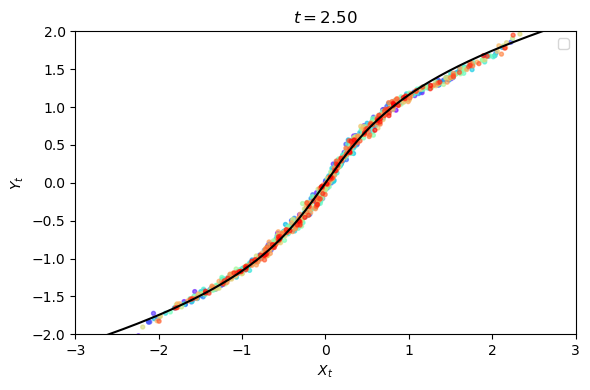

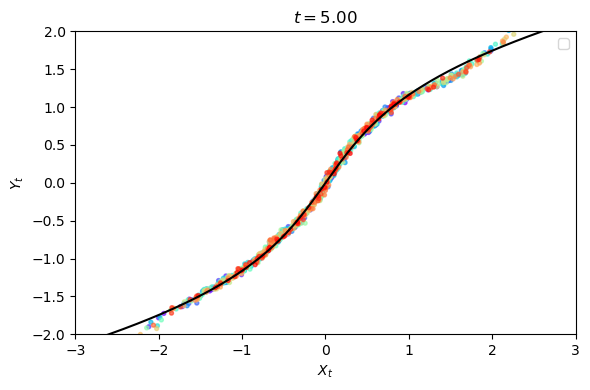

Done: k-NN–based mp4 animation and PNG snapshots saved.


In [7]:
# # --- 1) Full mp4 animation with k-NN–based conditionals ---
# ani_knn = animate_coupling(
#     Xt_knn, 
#     Yt_knn, 
#     errs_knn, 
#     t, 
#     T_map,
#     filepath='coupling_with_OT_curve_knn.mp4',
#     fps=15,
#     interval=60,
#     figsize=(11, 4),
#     cmap='rainbow'
# )

# --- 2) Static snapshots at chosen times (k-NN) ---
snapshot_times = [0.0, 1.0, 2.5, 5.0]
for tau in snapshot_times:
    save_scatter_snapshot(
        time_point=tau,
        t=t,
        X_traj=Xt_knn_imp,
        Y_traj=Yt_knn_imp,
        T_map=T_map,
        filename=f'scatter_knn_imp_t{tau:.2f}.png',
        figsize=(6, 4),
        cmap='rainbow'
    )

print("Done: k-NN–based mp4 animation and PNG snapshots saved.")

## Gaussian vs. Exponential (4-well)

/tmp/ipykernel_112375/1398411535.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pdf   /= np.trapz(pdf, y_grid)


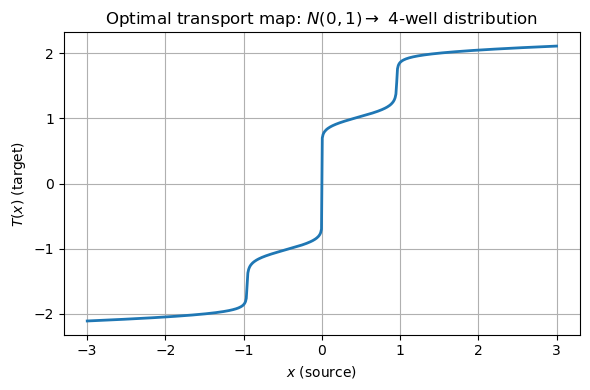

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import PchipInterpolator
import scipy.stats as st

# ------------------------------------------------------------------
# 1) SOURCE & 4-WELL TARGET UNNORMALISED DENSITY
# ------------------------------------------------------------------
phi   = st.norm()  # Φ(x)
beta  = 1.0
V     = lambda y: (y**2 - 1.0)**2 * (y**2 - 4.0)**2
p_unn = lambda y: np.exp(-beta * V(y))

# ------------------------------------------------------------------
# 2) BUILD TARGET CDF ON A GRID & DROP FLAT TAILS
# ------------------------------------------------------------------
y_grid = np.linspace(-6, 6, 40001)
pdf    = p_unn(y_grid)
pdf   /= np.trapz(pdf, y_grid)
cdf    = cumulative_trapezoid(pdf, y_grid, initial=0.0)

# only keep strictly-increasing bits
mask     = np.concatenate(([False], np.diff(cdf) > 0))
u_all    = cdf[mask]
y_all    = y_grid[mask]

# ------------------------------------------------------------------
# 3) RESTRICT TO THE φ(x) RANGE YOU NEED
# ------------------------------------------------------------------
x_min, x_max = -3.0, 3.0
u_min, u_max = phi.cdf(x_min), phi.cdf(x_max)

keep = (u_all >= u_min) & (u_all <= u_max)
u_vals = u_all[keep]
y_vals = y_all[keep]

# ------------------------------------------------------------------
# 4) BUILD THE MONOTONE C1 INVERSE CDF ON [u_min,u_max]
# ------------------------------------------------------------------
F_inv = PchipInterpolator(u_vals, y_vals)

# ------------------------------------------------------------------
# 5) TRANSPORT MAP T(x) = F_target^{-1}(Φ(x))
# ------------------------------------------------------------------
def T(x):
    return F_inv(phi.cdf(x))

# ------------------------------------------------------------------
# 6) PLOT THE “WAVY” MAP
# ------------------------------------------------------------------
x = np.linspace(x_min, x_max, 600)
plt.figure(figsize=(6,4))
plt.plot(x, T(x), lw=2)
plt.title('Optimal transport map: $N(0,1)\\to$ 4-well distribution')
plt.xlabel('$x$ (source)')
plt.ylabel('$T(x)$ (target)')
plt.grid(True)
plt.tight_layout()
plt.show()


### OLS

/tmp/ipykernel_112375/3110082723.py:35: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pdf /= np.trapz(pdf, y)


0.3376964712788681


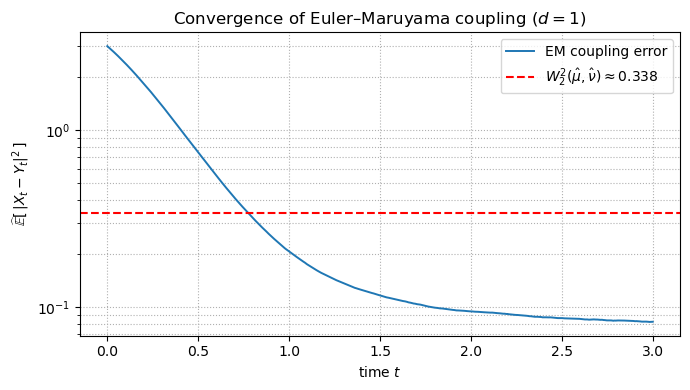

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import PchipInterpolator
import scipy.stats as st

# ---------------------------------------------------------------------
# 1.  Potentials and their gradients
# ---------------------------------------------------------------------
def compute_gradient_U(x):
    """∇U for the standard Gaussian μ(x) ∝ exp(−U(x))."""
    # U(x) = x²/2  (+ constant → gradient unchanged)
    return x

def compute_gradient_V(y):
    """∇V for the 4-well target ν(y) ∝ exp(−V(y))."""
    # V(y) = (y^2−1)^2 (y^2−4)^2
    # ⇒ dV/dy = 4 y (y^2−1)(y^2−4)(2y^2 − 5)
    return 4 * y * (y**2 - 1.0) * (y**2 - 4.0) * (2*y**2 - 5)

# ---------------------------------------------------------------------
# 2.  Sampling the 4-well distribution via its quantile function
# ---------------------------------------------------------------------
def build_four_well_quantile(beta=1.0, y_min=-6, y_max=6, ny=40001, tol=1e-6):
    """
    Return the inverse‐CDF F^{-1} of ν(y) ∝ exp[−β V(y)] for the 4-well,
    but drop the extreme CDF tails u<tol and u>1-tol so that no Δu is tiny.
    """
    # 1. Grid + unnormalised pdf
    y    = np.linspace(y_min, y_max, ny)
    V4w  = (y**2 - 1.0)**2 * (y**2 - 4.0)**2
    pdf  = np.exp(-beta * V4w)

    # 2. Normalise
    pdf /= np.trapz(pdf, y)

    # 3. Build CDF
    cdf  = cumulative_trapezoid(pdf, y, initial=0.0)

    # 4. Keep only strictly increasing points
    inc_mask = np.concatenate(([False], np.diff(cdf) > 0))
    u_all     = cdf[inc_mask]
    y_all     = y[inc_mask]

    # 5. Discard the extreme tails u<tol or u>1-tol
    keep      = (u_all >= tol) & (u_all <= 1 - tol)
    u_vals    = u_all[keep]
    y_vals    = y_all[keep]

    # 6. Build PCHIP on this “trimmed” [tol,1-tol] range
    return PchipInterpolator(u_vals, y_vals, extrapolate=True)



F_inv = build_four_well_quantile()
Phi   = st.norm().cdf
def sample_nu(n):
    return F_inv(Phi(np.random.randn(n)))


# ---------------------------------------------------------------------
# 3.  Euler–Maruyama coupling in 1-D
# ---------------------------------------------------------------------
num_samples = 1_000
epsilon     = 1e-3
T           = 3
N           = 500
dt          = T / N
sqrt_2eps_dt = np.sqrt(2 * epsilon * dt)

# initial samples
X = np.random.randn(num_samples)       # μ = N(0,1)
Y = sample_nu(num_samples)             # ν  (four well)

X_traj = np.empty((N + 1, num_samples))
Y_traj = np.empty_like(X_traj)
X_traj[0] = X
Y_traj[0] = Y

errors = np.empty(N + 1)
errors[0] = np.mean((X - Y) ** 2)

W2_init = W2_empirical(X_traj[0], Y_traj[0])
W2_sq   = W2_init**2
print(W2_sq)

# time stepping
for n in range(N):
    # read old values
    X_old = X_traj[n]
    Y_old = Y_traj[n]

    # conditional means via OLS
    cond_mean_Y_given_X, _, _ = compute_ols_parameters(X_old, Y_old)
    cond_mean_X_given_Y, _, _ = compute_ols_parameters(Y_old, X_old)

    # gradients
    gradU = compute_gradient_U(X_old)
    gradV = compute_gradient_V(Y_old)

    # Brownian increments
    dW = sqrt_2eps_dt * np.random.randn(num_samples)
    dB = sqrt_2eps_dt * np.random.randn(num_samples)

    # Euler–Maruyama update
    X_traj[n + 1] = X_old + (Y_old - cond_mean_Y_given_X - epsilon * gradU) * dt + dW
    Y_traj[n + 1] = Y_old + (X_old - cond_mean_X_given_Y - epsilon * gradV) * dt + dB

    # compute error
    errors[n + 1] = np.mean((X_traj[n + 1] - Y_traj[n + 1]) ** 2)

# ---------------------------------------------------------------------
# 4.  Diagnostic plot
# ---------------------------------------------------------------------
t = np.linspace(0, T, N + 1)
plt.figure(figsize=(7, 4))
plt.semilogy(t, errors, lw=1.4, label='EM coupling error')
plt.axhline(
    y=W2_sq,
    color='red',
    linestyle='--',
    label=rf'$W_2^2(\hat\mu,\hat\nu)\approx {W2_sq:.3f}$'
)
plt.xlabel('time $t$')
plt.ylabel(r'$\widehat{\mathbb{E}}[\,|X_t-Y_t|^2\,]$')
plt.legend()
plt.title('Convergence of Euler–Maruyama coupling ($d=1$)')
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()

In [12]:
# import matplotlib.animation as animation
# T_map = lambda x: F_inv(Phi(x))

# # curve to draw in the scatter plot
# x_curve = np.linspace(-3, 3, 600)
# y_curve = T_map(x_curve)

# # -------------------------------------------------------------------------
# # 2.  Animation figure layout
# # -------------------------------------------------------------------------
# fig, (ax_xy, ax_err) = plt.subplots(1, 2, figsize=(11, 4))
# particle_colors = plt.cm.rainbow(np.linspace(0, 1, num_samples))

# # left panel: scatter (X_t, Y_t) + OT curve
# ax_xy.plot(x_curve, y_curve, color='k', lw=1.5, label=r'optimal map $y=T(x)$')
# scatter = ax_xy.scatter([], [], s=8, alpha=0.65)
# time_text = ax_xy.text(0.02, 0.95, '', transform=ax_xy.transAxes,
#                     va='top', ha='left', fontsize=9)
# ax_xy.set_xlabel(r'$X_t$')
# ax_xy.set_ylabel(r'$Y_t$')
# ax_xy.set_xlim(x_curve[0], x_curve[-1])
# ax_xy.set_ylim(y_curve.min(), y_curve.max())
# ax_xy.legend()

# # right panel: convergence curve with live marker
# ax_err.semilogy(t, errors, lw=1.4, color='C1')
# marker = ax_err.scatter([], [], color='red', zorder=3)
# ax_err.set_xlabel('time $t$')
# ax_err.set_ylabel(r'$\mathbb{E}[\,|X_t-Y_t|^2\,]$')
# ax_err.grid(True, which='both', ls=':')

# # -------------------------------------------------------------------------
# # 3.  Animation callbacks
# # -------------------------------------------------------------------------
# def init():
#     scatter.set_offsets(np.empty((0, 2)))
#     marker.set_offsets(np.empty((0, 2)))
#     time_text.set_text('')
#     return scatter, marker, time_text

# def update(frame):
#     # update scatter with current particles
#     pts = np.column_stack((X_traj[frame], Y_traj[frame]))
#     scatter.set_offsets(pts)               # move the markers
#     scatter.set_facecolor(particle_colors) # apply the palette

#     # update marker on the convergence curve
#     marker.set_offsets([[t[frame], errors[frame]]])

#     # update time label
#     time_text.set_text(fr'$t = {t[frame]:.2f}$')
#     return scatter, marker, time_text

# ani = animation.FuncAnimation(fig, update, frames=len(t),
#                             init_func=init, interval=60, blit=True)

# # -------------------------------------------------------------------------
# # 4.  Save or display
# # -------------------------------------------------------------------------
# ani.save('coupling_with_OT_curve_polReg_4well.mp4', writer='ffmpeg', dpi=150, fps=15)
# print('Animation saved as coupling_with_OT_curve_polReg_4well.mp4')

# plt.tight_layout()
# plt.show()

### Nadaraya-Warson

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import PchipInterpolator
import scipy.stats as st
from cond_expect_ols import compute_ols_parameters

# ---------------------------------------------------------------------
# 1.  Potentials and their gradients
# ---------------------------------------------------------------------
def compute_gradient_U(x):
    """∇U for the standard Gaussian μ(x) ∝ exp(−U(x))."""
    # U(x) = x²/2  (+ constant → gradient unchanged)
    return x

def compute_gradient_V(y):
    """∇V for the 4-well target ν(y) ∝ exp(−V(y))."""
    # V(y) = (y^2−1)^2 (y^2−4)^2
    # ⇒ dV/dy = 4 y (y^2−1)(y^2−4)(2y^2 − 5)
    return 4 * y * (y**2 - 1.0) * (y**2 - 4.0) * (2*y**2 - 5)

# ---------------------------------------------------------------------
# 2.  Sampling the 4-well distribution via its quantile function
# ---------------------------------------------------------------------
def build_four_well_quantile(beta=1.0, y_min=-6, y_max=6, ny=40001, tol=1e-6):
    """
    Return the inverse‐CDF F^{-1} of ν(y) ∝ exp[−β V(y)] for the 4-well,
    but drop the extreme CDF tails u<tol and u>1-tol so that no Δu is tiny.
    """
    # 1. Grid + unnormalised pdf
    y    = np.linspace(y_min, y_max, ny)
    V4w  = (y**2 - 1.0)**2 * (y**2 - 4.0)**2
    pdf  = np.exp(-beta * V4w)

    # 2. Normalise
    pdf /= np.trapz(pdf, y)

    # 3. Build CDF
    cdf  = cumulative_trapezoid(pdf, y, initial=0.0)

    # 4. Keep only strictly increasing points
    inc_mask = np.concatenate(([False], np.diff(cdf) > 0))
    u_all     = cdf[inc_mask]
    y_all     = y[inc_mask]

    # 5. Discard the extreme tails u<tol or u>1-tol
    keep      = (u_all >= tol) & (u_all <= 1 - tol)
    u_vals    = u_all[keep]
    y_vals    = y_all[keep]

    # 6. Build PCHIP on this “trimmed” [tol,1-tol] range
    return PchipInterpolator(u_vals, y_vals, extrapolate=True)



F_inv = build_four_well_quantile()
Phi   = st.norm().cdf
def sample_nu(n):
    return F_inv(Phi(np.random.randn(n)))


# ---------------------------------------------------------------------
# 3.  Euler–Maruyama coupling in 1-D
# ---------------------------------------------------------------------
num_samples = 1_000
epsilon     = 1e-3
T           = 5
N           = 500
dt          = T / N
sqrt_2eps_dt = np.sqrt(2 * epsilon * dt)
h = 0.01

# initial samples
X = np.random.randn(num_samples)       # μ = N(0,1)
Y = sample_nu(num_samples)             # ν  (double well)

# storage
X_traj = np.empty((N + 1, num_samples))
Y_traj = np.empty_like(X_traj)
X_traj[0] = X
Y_traj[0] = Y
errors = np.empty(N + 1)
errors[0] = np.mean((X - Y) ** 2)
for n in range(N):
    # read the "old" positions
    X_old = X_traj[n]
    Y_old = Y_traj[n]

    # conditional means via Nadaraya–Watson
    m_Y_given_X = nadaraya_watson(X_old, X_old, Y_old, h)
    m_X_given_Y = nadaraya_watson(Y_old, Y_old, X_old, h)

    # gradients
    gU = compute_gradient_U(X_old)
    gV = compute_gradient_V(Y_old)

    # Brownian increments
    dW = sqrt_2eps_dt * np.random.randn(num_samples)
    dB = sqrt_2eps_dt * np.random.randn(num_samples)

    # Euler step into the trajectory arrays
    X_traj[n+1] = X_old + (Y_old - m_Y_given_X - epsilon * gU) * dt + dW
    Y_traj[n+1] = Y_old + (X_old - m_X_given_Y - epsilon * gV) * dt + dB

    # error at the new time step
    errors[n+1] = np.mean((X_traj[n+1] - Y_traj[n+1])**2)
# ------------------------------------------------------------------
# 5.  Plot convergence
# ------------------------------------------------------------------
t = np.linspace(0, T, N + 1)
plt.figure(figsize=(7, 4))
plt.semilogy(t, errors, lw=1.4, label='EM coupling error')
plt.axhline(
    y=W2_sq,
    color='red',
    linestyle='--',
    label=rf'$W_2^2(\hat\mu,\hat\nu)\approx {W2_sq:.3f}$'
)
plt.xlabel('time $t$')
plt.ylabel(r'$\widehat{\mathbb{E}}[\,|X_t-Y_t|^2\,]$')
plt.legend()
plt.title('Convergence of Euler–Maruyama coupling ($d=1$)')
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()



ModuleNotFoundError: No module named 'cond_expect_ols'

Animation saved as coupling_with_OT_curve_Nadaraya_4well.mp4


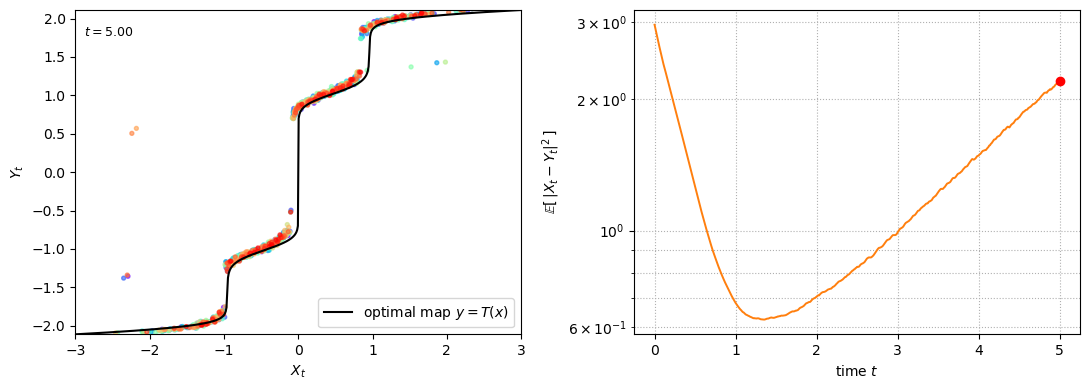

In [ ]:
# import matplotlib.animation as animation
# T_map = lambda x: F_inv(Phi(x))

# # curve to draw in the scatter plot
# x_curve = np.linspace(-3, 3, 600)
# y_curve = T_map(x_curve)

# # -------------------------------------------------------------------------
# # 2.  Animation figure layout
# # -------------------------------------------------------------------------
# fig, (ax_xy, ax_err) = plt.subplots(1, 2, figsize=(11, 4))
# particle_colors = plt.cm.rainbow(np.linspace(0, 1, num_samples))

# # left panel: scatter (X_t, Y_t) + OT curve
# ax_xy.plot(x_curve, y_curve, color='k', lw=1.5, label=r'optimal map $y=T(x)$')
# scatter = ax_xy.scatter([], [], s=8, alpha=0.65)
# time_text = ax_xy.text(0.02, 0.95, '', transform=ax_xy.transAxes,
#                     va='top', ha='left', fontsize=9)
# ax_xy.set_xlabel(r'$X_t$')
# ax_xy.set_ylabel(r'$Y_t$')
# ax_xy.set_xlim(x_curve[0], x_curve[-1])
# ax_xy.set_ylim(y_curve.min(), y_curve.max())
# ax_xy.legend()

# # right panel: convergence curve with live marker
# ax_err.semilogy(t, errors, lw=1.4, color='C1')
# marker = ax_err.scatter([], [], color='red', zorder=3)
# ax_err.set_xlabel('time $t$')
# ax_err.set_ylabel(r'$\mathbb{E}[\,|X_t-Y_t|^2\,]$')
# ax_err.grid(True, which='both', ls=':')

# # -------------------------------------------------------------------------
# # 3.  Animation callbacks
# # -------------------------------------------------------------------------
# def init():
#     scatter.set_offsets(np.empty((0, 2)))
#     marker.set_offsets(np.empty((0, 2)))
#     time_text.set_text('')
#     return scatter, marker, time_text

# def update(frame):
#     # update scatter with current particles
#     pts = np.column_stack((X_traj[frame], Y_traj[frame]))
#     scatter.set_offsets(pts)               # move the markers
#     scatter.set_facecolor(particle_colors) # apply the palette

#     # update marker on the convergence curve
#     marker.set_offsets([[t[frame], errors[frame]]])

#     # update time label
#     time_text.set_text(fr'$t = {t[frame]:.2f}$')
#     return scatter, marker, time_text

# ani = animation.FuncAnimation(fig, update, frames=len(t),
#                             init_func=init, interval=60, blit=True)

# # -------------------------------------------------------------------------
# # 4.  Save or display
# # -------------------------------------------------------------------------
# ani.save('coupling_with_OT_curve_Nadaraya_4well.mp4', writer='ffmpeg', dpi=150, fps=15)
# print('Animation saved as coupling_with_OT_curve_Nadaraya_4well.mp4')

# plt.tight_layout()
# plt.show()